# 1. Object Detection

### 1.1 Introduction & Approach

Starting off, I'll assume that the image given is generated via some image generation tool such as OpenAI's APIs, Midjourney's API, etc. I'll also assume that the image itself is first seen by the person generating it before using it in any context. However, there as most generative models results are not deterministic - we cannot control the outcome of the generated image. A naive way to approach this is to look precisely at the objects that are inside an image.

For example, if the generated image was created via a prompt such as: "a cat and a dog sleeping next to each other", and the object detection model doesn't get either of this with a high enough confidence, then it's likely that the generated image didn't contain either of these 2 key objects from the prompt (this also heavily depends on how the object detection model is trained and how accurate it is). This mechanism is also well suited for short-circuiting/retrying in case of faulty outputs.

Furthermore, there is a beneficial side-effect from this approach that we can tap into. The objects detected from an image can be used as *tags* to make searching and categorisation easier (in our example that would be: \[cat, dog]). We can also further extend this by clustering the outputs so that our cat and dog example could be a part of a bigger categorisation cluster (for our example - animals/pets). However, this can be done only after having enough certainty in the model's capabilities based on some metrics - mean average precision, recall, F1 or AUC for balanced and imbalanced datasets respectively.

### 1.2 Experiment

For this quick PoC, I'll be using YOLOv8 - a robust, fast, and accurate model trained on the COCO dataset. I picked YOLO because it's well-known and has a couple of advantages when it comes to creating PoCs:
1. It's pretrained on the COCO dataset which has 80 categories.
2. The library is convenient and does most of the heavy-lifting.
3. If I'd want to extend it, I can fine-tune it on my own dataset with relative ease and I'd still be confident in reasonable results.

#### 1.2.1 Preamble

In [1]:
from ultralytics import YOLO
from PIL import Image
import numpy as np

model = YOLO(model="../../models/yolo/weights/yolov8n.pt",)
results = model.predict("../assets/meow_and_woof.jpg")


image 1/1 /Users/michaelb/Projects/python/image-caption-generator/exploration/01_grounded_label_box_detection/../assets/meow_and_woof.jpg: 352x640 1 cat, 1 dog, 83.8ms
Speed: 4.6ms preprocess, 83.8ms inference, 6.4ms postprocess per image at shape (1, 3, 352, 640)


#### 1.2.2 Visualisation

In [2]:
for result in results:
    im_array = result.plot()
    im = Image.fromarray(im_array[..., ::-1])

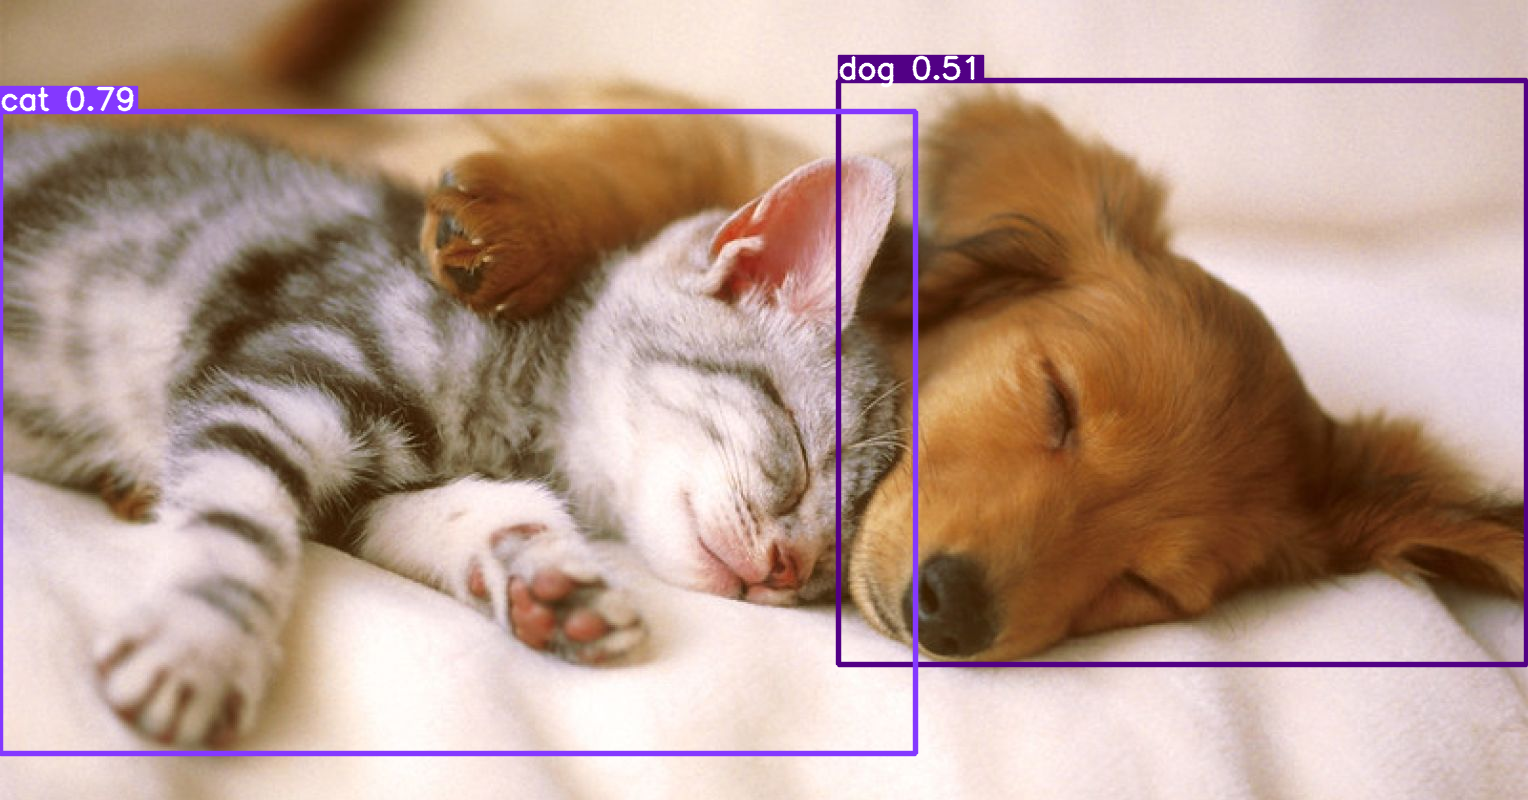

In [3]:
im

### 1.3 Conclusion & Next Steps

In conclusion, object detection is a viable albeit naive approach to solve the problem of categorisation and keyword searching. It has some notable upsides, namely:
* It can be easily extended/fine-tuned - having a well-labelled domain-specific dataset for fine-tuning would improve performance as the categories are already known (or not known if we put negative examples).
* It's convenient - well-written API that is also well-documented

There is also room for improvement. For example, the bounding boxes are overlapping at places such as where the dog's paw is considered a part of the cat, whereas the dog is only the head. We also rely on how the model is trained so if an unknown category is presented, we don't want to just pass on it. Here are some possible improvements:
* Multi-boxes could work and get us only so far. We need something tigher such as a segmentation mask. That would give us proper object constraints that would capture the dog with its paw and the cat without the dog's paw.
* Since we have access to the prompt used to generate an image we can use specific words to extract categories for. For example, if we are only interested in a cat and a dog, do we need to know whether we've found a bed or if we're given a faulty label such as backpack or something similar. Further constraining the model would give us more precise results.